In [9]:
import numpy as np
import cv2
from show_image import show_rgb_image
from show_image import show_images
from datascience import *
%matplotlib inline

---

- ## 히스토그램 평활화

- <h4 style="color: red; font-weight: bold;">아래 영상은 밝기의 최대값과 최소값이 양 끝에 존재하므로 스트레칭으로는 명암 향상이 불가능하다.</h4>

[[33 25 23 ..., 29 30 30]
 [22 19 16 ..., 23 23 22]
 [24 18 17 ..., 21 23 24]
 ..., 
 [18 19 20 ..., 70 63 64]
 [19 21 21 ..., 69 64 66]
 [18 19 18 ..., 67 64 65]]


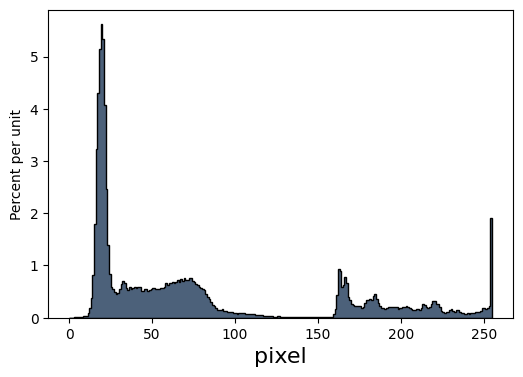

In [115]:
image = cv2.imread("./images/chap06/equalize.jpg", cv2.IMREAD_GRAYSCALE)
print(image)
Table().with_columns("pixel", image.reshape(-1)).hist(bins=np.arange(0, 256, 1))

<br>

- ### 분포의 균등을 이용하여 명암 대비를 증가

- #### 1. 히스토그램 빈도값에서 누적 빈도수를 계산

In [121]:
max_pixel = np.max(image)

image_hist = np.zeros(max_pixel + 1, dtype="float32")
for pixel in image.flatten():
    image_hist[pixel] += 1

image_hist_table = Table().with_columns(
    "밝기", np.arange(0, max_pixel + 1, 1),
    "빈도수", image_hist,
    "누적합", image_hist.cumsum()
)
image_hist_table

밝기,빈도수,누적합
0,4,4
1,6,10
2,7,17
3,17,34
4,20,54
5,17,71
6,19,90
7,36,126
8,44,170
9,60,230


- #### 2. 누적 빈도수를 크기가 1인 데이터로 정규화
    - #### 정규화 누적합 = 각 누적 빈도수 / 전체 빈도수의 합

In [122]:
image_hist_table = image_hist_table.with_column(
    "정규화 누적합", image_hist.cumsum() / image_hist.sum()
)
image_hist_table

밝기,빈도수,누적합,정규화 누적합
0,4,4,2.31481e-05
1,6,10,5.78704e-05
2,7,17,9.83796e-05
3,17,34,0.000196759
4,20,54,0.0003125
5,17,71,0.00041088
6,19,90,0.000520833
7,36,126,0.000729167
8,44,170,0.000983796
9,60,230,0.00133102


- #### 3. 결과 화소값 = (정규화 누적합 * 화소 최대값)을 소수점 첫째 자리에서 반올림

In [123]:
image_hist_table = image_hist_table.with_column(
    "결과 화소값", (image_hist_table.column("정규화 누적합") * max_pixel).astype("uint8")
)
image_hist_table.show(20)

밝기,빈도수,누적합,정규화 누적합,결과 화소값
0,4,4,2.31481e-05,0
1,6,10,5.78704e-05,0
2,7,17,9.83796e-05,0
3,17,34,0.000196759,0
4,20,54,0.0003125,0
5,17,71,0.00041088,0
6,19,90,0.000520833,0
7,36,126,0.000729167,0
8,44,170,0.000983796,0
9,60,230,0.00133102,0


[[104  92  89 ...,  97  99  99]
 [ 85  55  16 ...,  89  89  85]
 [ 91  41  27 ...,  79  89  91]
 ..., 
 [ 41  55  69 ..., 161 148 150]
 [ 55  79  79 ..., 159 150 153]
 [ 41  55  41 ..., 155 150 152]]


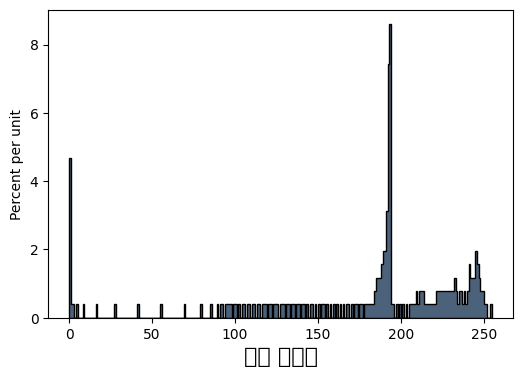

In [124]:
new_image = np.zeros(image.shape, dtype="uint8")

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        curr_bright = image.item(y, x)
        new_bright = image_hist_table.take(curr_bright).column("결과 화소값")[0]
        new_image.itemset((y, x), new_bright)

print(new_image)
image_hist_table.hist("결과 화소값", bins=np.arange(0, 256, 1))

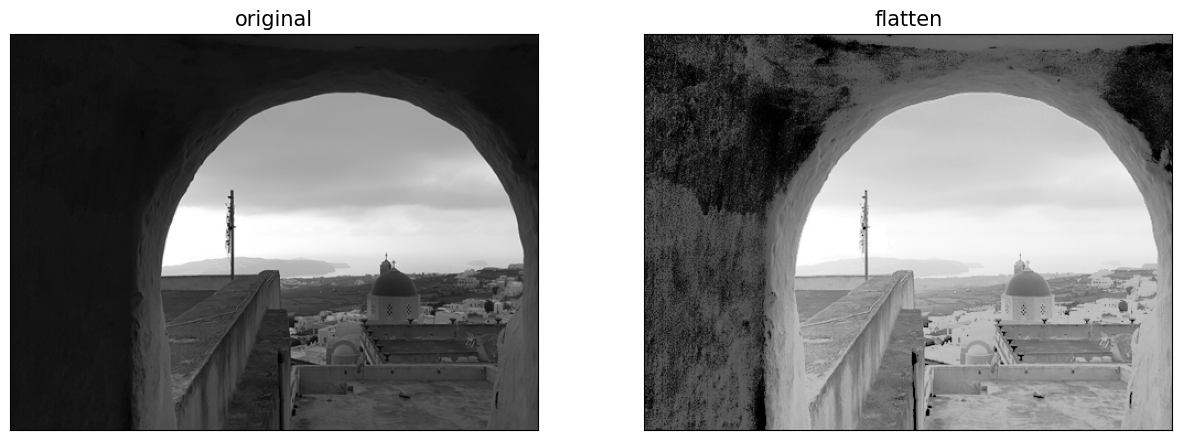

In [125]:
show_images({"original": image, "flatten": new_image}, 15)

---

- ## 컬러 공간

- ### 1. RGB 컬러 공간
    - #### 가산 혼합: 섞을수록 밝아짐
        - #### White: (255, 255, 255)
    - #### (R, G, B) 빛의 삼원색 사용

- ### 2. CMY(K) 컬러 공간
    - #### 인쇄에 사용됨
    - #### 감산 혼합: 섞을수록 어두워짐
    - #### 청록(Cyan), 자홍(Magenta), 노랑색(Yellow) 색의 삼원색 사용
    - #### K: 순수한 검정색
    - #### RGB와 보색 관계
        - #### C = 255 - R
        - #### M = 255 - G
        - #### Y = 255 - B
        - #### K = min(C, M, Y)

<br>

- ### BGR -> CMYK 변환

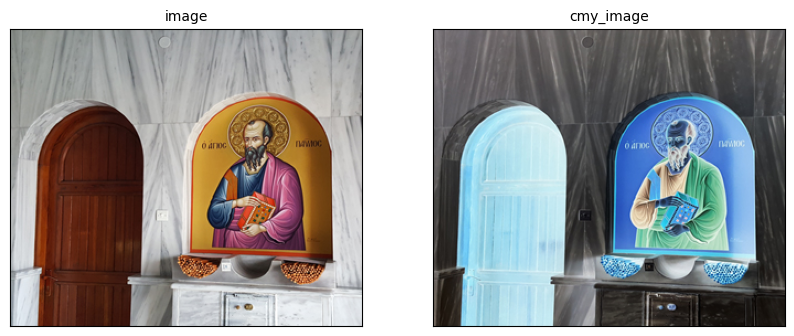

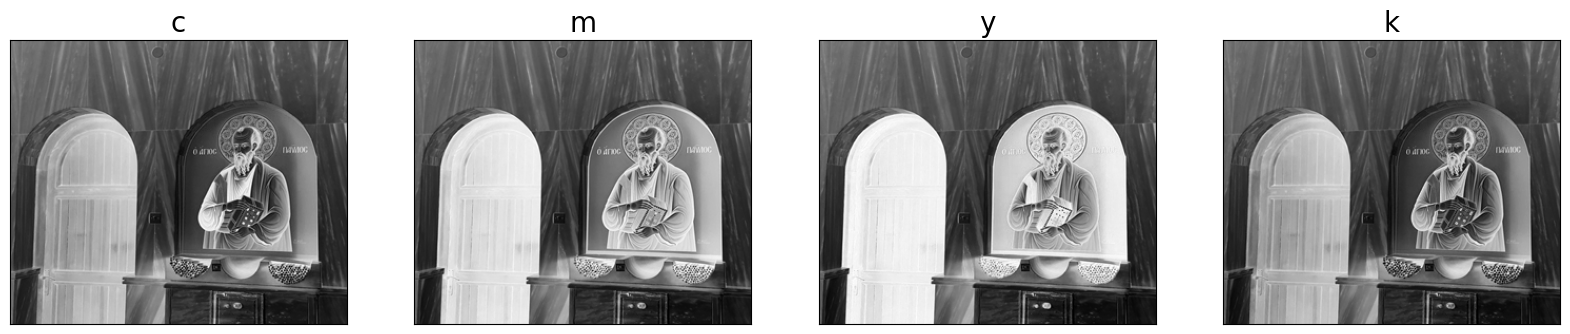

In [149]:
image = cv2.imread("./images/chap06/color_model.jpg", cv2.IMREAD_COLOR)

white_image = np.full(image.shape, 255)
cmy_image = np.uint8(white_image - image)
show_images({"image": image, "cmy_image": cmy_image}, 10)

y_image, m_image, c_image = cv2.split(cmy_image)
k_image = cv2.min(y_image, cv2.min(m_image, c_image))
show_images({"c": c_image, "m": m_image, "y": y_image, "k": k_image}, 20)

<br><br>

- ### 3. HSV 컬러 공간
    - #### Hue: 색상
        - #### $0^\circ$: 빨간색
        - #### $60^\circ$: 노란색
        - #### $120^\circ$: 초록색
        - #### $180^\circ$: 청록색
        - #### $240^\circ$: 파란색
        - #### $300^\circ$: 다홍색

    <br>

    - #### Saturation: 채도
        - #### 색의 순수한 정도
        - #### 흰색 혼합 비율이 늘어날수록 줄어듬

    <br>
    
    - #### Intensity: 명도
        - #### 빛의 세기

<br>

- ### BGR -> HSV 변환
    - ### cv2.cvtColor(image, code)

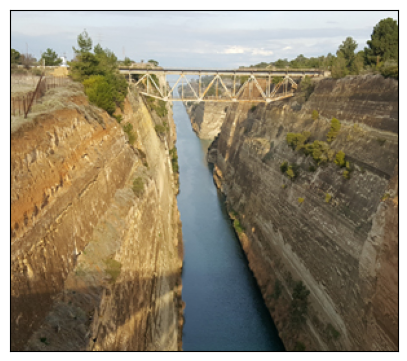

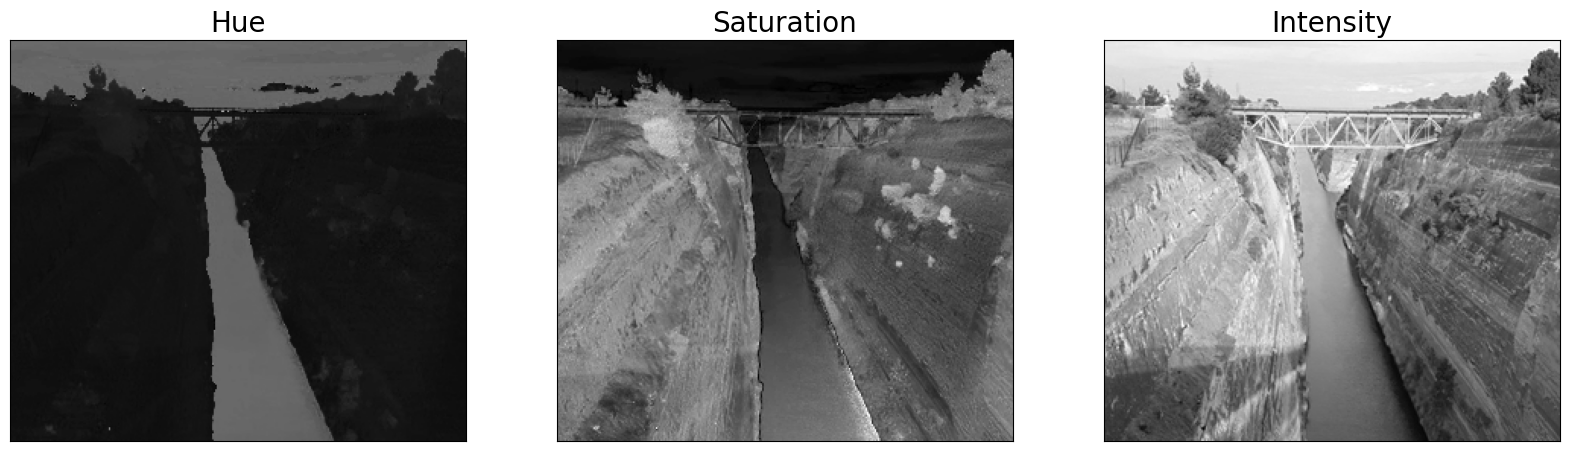

In [155]:
image = cv2.imread("./images/chap06/color_space.jpg", cv2.IMREAD_COLOR)

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

Hue, Saturation, Intensity = cv2.split(hsv_image)

show_images({"": image}, 5)
show_images({"Hue": Hue, "Saturation": Saturation, "Intensity": Intensity}, 20)

- #### Hue
    - #### $0^\circ$에 가까운 브라운 계열은 어둡게 나타남
    - #### $240^\circ$에 가까운 푸른 계열은 밝게 나타남
 
<br>

- #### Saturation
    - #### 흰색 혼합 비율이 높은 푸른색 계열은 어둡게 나타남
    - #### 흰색 혼합 비율이 적은 브라운 계열은 밝게 나타남

<br>

- #### Intensity
    - #### 명도값이므로 GrayScale 이미지와 같은 형태

<br><br>

- ### 4. YCbCr 컬러 공간
    - #### 화질 큰 저하 없이 효과적인 압축 가능
  
    <br>
    
    - #### Y: 흑백 성분, 밝기
    - #### Cb: 파란색 색차
    - #### Cr: 빨간색 색차

<br>

- ### BGR -> YCbCr 변환

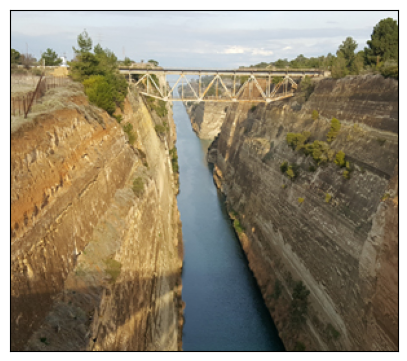

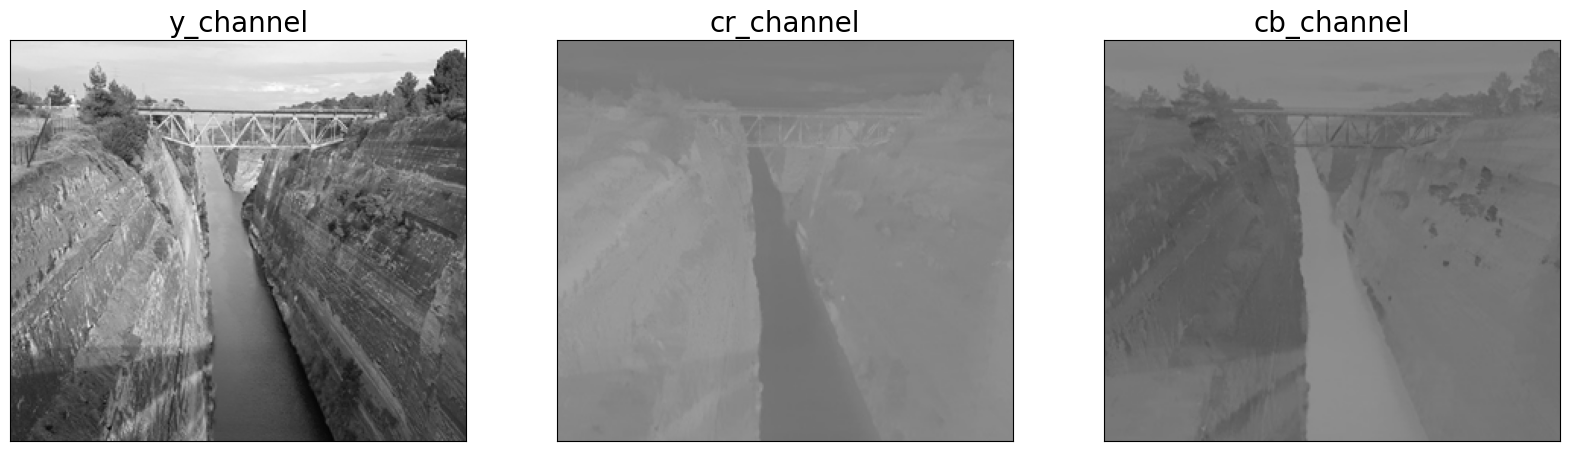

In [158]:
image = cv2.imread("./images/chap06/color_space.jpg", cv2.IMREAD_COLOR)
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

y_channel, cr_channel, cb_channel = cv2.split(ycbcr_image)

show_images({"": image}, 5)
show_images({"y_channel": y_channel, "cr_channel": cr_channel, "cb_channel": cb_channel}, 20)

- #### Y 채널
    - #### 밝기 성분이므로 GrayScale 이미지와 유사
 
<br>

- #### CR 채널
    - #### Red 색차이므로 붉은 계열이 밝게 나타남
 
<br>

- #### CB 채널
    - #### Blue 색차이므로 푸른 계열이 밝게 나타남

---